In [5]:
# import mlflow
# import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import LabelEncoder
import torch
import math 

# More Complex CNN

In [6]:
# Configuration
DATA_DIR = '../data/data_normalized_exp2'
# DATA_DIR = 'C:/Users/franc/Downloads/data_normalized_exp2'
SEQ_LENGTH = 5000
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.0005
EXPERIMENT_NAME = "IEEG_Classification_CNN"
RUN_NAME = "CNN"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = SEQ_LENGTH

In [7]:
class IeegDataset(Dataset):
    def __init__(self, data_dir, seq_length=5000):
        self.data_dir = data_dir
        self.seq_length = seq_length
        self.signals = []
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Recorre los archivos dentro del directorio principal
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.csv'):
                    self.signals.append(os.path.join(root, file))
                    # Extraer etiqueta del nombre del archivo (antes del primer guion bajo)
                    label = file.split('_')[0]
                    self.labels.append(label)

        if not self.signals:
            print(f"No CSV files found in {data_dir}")
            return

        # Imprimir las etiquetas antes de la codificación
        print("Etiquetas antes de la codificación:", self.labels)

        # Convertir etiquetas a valores numéricos
        if self.labels:
            self.labels = self.label_encoder.fit_transform(self.labels)
        
        # Imprimir las etiquetas después de la codificación
        print("Etiquetas después de la codificación:", self.labels)

        data_temp = []
        labels_temp = []
        for file_path, label in zip(self.signals, self.labels):
            print(f"Loading file: {file_path}")
            try:
                df = pd.read_csv(file_path)
            except PermissionError as e:
                print(f"Permission denied: {e}")
                continue
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue
            
            for column in df.columns: 
                for idx in range(0, math.floor(df.shape[0] / self.seq_length)):
                    segment = df[column].values[idx * self.seq_length : (idx + 1) * self.seq_length]
                    if len(segment) == self.seq_length:
                        data_temp.append(segment)
                        labels_temp.append(label)
        
        # Convertir a tensores
        if data_temp:
            self.data = torch.tensor(data_temp, dtype=torch.float32)
            self.labels = torch.tensor(labels_temp, dtype=torch.long)
        else:
            print("No data segments found.")
            self.data = torch.tensor([], dtype=torch.float32)
            self.labels = torch.tensor([], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.labels[idx]

    def get_class_mapping(self):
        return {i: class_name for i, class_name in enumerate(self.label_encoder.classes_)}

# Función para crear DataLoaders
def create_data_loaders(dataset, batch_size):
    labels = np.array([dataset[i][1].item() for i in range(len(dataset))])
    if len(labels) == 0:
        raise ValueError("No labels found in the dataset.")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_index, test_index = next(sss.split(np.zeros(len(labels)), labels))

    train_dataset = Subset(dataset, train_index)
    test_dataset = Subset(dataset, test_index)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [4]:
# Define Model
class Deep_CNN_Signals(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Deep_CNN_Signals, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(512 * (input_size // 16), 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        feature_maps = []
        x = self.relu(self.bn1(self.conv1(x)))
        feature_maps.append(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        feature_maps.append(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        feature_maps.append(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = self.relu(self.bn4(self.conv4(x)))
        feature_maps.append(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x, feature_maps


In [5]:
def plot_feature_maps(feature_maps):
    for layer_idx, feature_map in enumerate(feature_maps):
        num_features = feature_map.shape[1]
        size = feature_map.shape[2]
        
        fig, axes = plt.subplots(1, num_features, figsize=(num_features * 2, 2))
        fig.suptitle(f'Layer {layer_idx + 1} Feature Maps')
        
        for i in range(num_features):
            if num_features > 1:
                axes[i].plot(feature_map[0, i].detach().cpu().numpy())
            else:
                axes.plot(feature_map[0, i].detach().cpu().numpy())
        
        plt.show()

In [6]:
# # Data Loaders and Partitioning
# def create_data_loaders(dataset, batch_size):
#     labels = np.array([dataset[i][1].item() for i in range(len(dataset))])
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#     train_index, test_index = next(sss.split(np.zeros(len(labels)), labels))

#     train_dataset = Subset(dataset, train_index)
#     test_dataset = Subset(dataset, test_index)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     return train_loader, test_loader

In [7]:
# Plotting Functions
def plot_pie_chart(counts, class_names, title):
    fig, ax = plt.subplots()
    ax.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90, counterclock=False)
    ax.axis('equal')
    plt.title(title)
    return fig

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [13]:
# Training Function
def train_model(model, train_loader, optimizer, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        y_true_train = []
        y_pred_train = []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(labels.squeeze().cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

            avg_loss = running_loss / len(train_loader)
            train_accuracy = accuracy_score(y_true_train, y_pred_train)
            precision, recall, f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted', zero_division=0)

            progress_bar.set_postfix(loss=avg_loss, accuracy=train_accuracy, precision=precision, recall=recall, f1=f1)

        mlflow.log_metric("train_loss", avg_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
        mlflow.log_metric("train_precision", precision, step=epoch)
        mlflow.log_metric("train_recall", recall, step=epoch)
        mlflow.log_metric("train_f1", f1, step=epoch)

# Evaluation Function
def evaluate_model(model, test_loader, dataset, device, img_path, run_name):
    model.eval()
    y_true_test = []
    y_pred_test = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, feature_maps = model(inputs)
            plot_feature_maps(feature_maps)
            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.squeeze().cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted', zero_division=0)

    print(f'Accuracy of the model on the test data: {test_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    # mlflow.log_metric("test_accuracy", test_accuracy)
    # mlflow.log_metric("test_precision", precision)
    # mlflow.log_metric("test_recall", recall)
    # mlflow.log_metric("test_f1", f1)

    # Confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    cm_df = pd.DataFrame(cm, index=dataset.label_encoder.classes_, columns=dataset.label_encoder.classes_)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    img_file = os.path.join(img_path, f"confusion_matrix_{run_name}.png")
    plt.savefig(img_file)
    # mlflow.log_artifact(img_file)
    plt.close()

In [14]:
# # Verifica que tienes los datos de DVC
# os.system('dvc pull')

In [8]:
dataset = IeegDataset(DATA_DIR, SEQ_LENGTH)

NUM_CLASSES = len(dataset.label_encoder.classes_)

Etiquetas antes de la codificación: ['CA', 'CA1', 'CA', 'vM1', 'CA', 'vM1', 'CA', 'CA', 'CA', 'vM1', 'CA', 'CA1', 'vM1', 'vM1', 'CxM1 LPF', 'vM1', 'CxM1 LPF', 'Thalamus', 'CA', 'CA', 'vM1', 'CA', 'CA', 'vM1', 'CA', 'vM1', 'CA', 'vM1', 'Thalamus', 'CA', 'vM1', 'vM1', 'Thalamus', 'vM1', 'vM1', 'vM1', 'CxM1 LPF', 'vM1', 'vM1', 'vM1', 'vM1']
Etiquetas después de la codificación: [0 1 0 4 0 4 0 0 0 4 0 1 4 4 2 4 2 3 0 0 4 0 0 4 0 4 0 4 3 0 4 4 3 4 4 4 2
 4 4 4 4]
Loading file: ../data/data_normalized_exp2/CA_17315012_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA1_18306013_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901007_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/vM1_15901012_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901009_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/vM1_15901007_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901010_resampled_clase_2

/tmp/ipykernel_47742/1435999915.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.data = torch.tensor(data_temp, dtype=torch.float32)


In [15]:
dataset = IeegDataset(DATA_DIR, SEQ_LENGTH)

if len(dataset) == 0:
    raise ValueError("No data found in the dataset.")

train_loader, test_loader = create_data_loaders(dataset, BATCH_SIZE)
NUM_CLASSES = len(dataset.label_encoder.classes_)

Etiquetas antes de la codificación: ['CA', 'CA1', 'CA', 'vM1', 'CA', 'vM1', 'CA', 'CA', 'CA', 'vM1', 'CA', 'CA1', 'vM1', 'vM1', 'CxM1 LPF', 'vM1', 'CxM1 LPF', 'Thalamus', 'CA', 'CA', 'vM1', 'CA', 'CA', 'vM1', 'CA', 'vM1', 'CA', 'vM1', 'Thalamus', 'CA', 'vM1', 'vM1', 'Thalamus', 'vM1', 'vM1', 'vM1', 'CxM1 LPF', 'vM1', 'vM1', 'vM1', 'vM1']
Etiquetas después de la codificación: [0 1 0 4 0 4 0 0 0 4 0 1 4 4 2 4 2 3 0 0 4 0 0 4 0 4 0 4 3 0 4 4 3 4 4 4 2
 4 4 4 4]
Loading file: ../data/data_normalized_exp2/CA_17315012_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA1_18306013_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901007_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/vM1_15901012_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901009_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/vM1_15901007_resampled_clase_2.csv
Loading file: ../data/data_normalized_exp2/CA_15901010_resampled_clase_2

/tmp/ipykernel_20336/1435999915.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.data = torch.tensor(data_temp, dtype=torch.float32)


Batch 1/2
Inputs shape: torch.Size([64, 1, 5000])
Labels shape: torch.Size([64])
Labels: tensor([1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 0, 1, 4, 0, 0, 2, 4, 0, 3, 0, 0, 0, 3, 0,
        2, 0, 0, 3, 0, 1, 3, 4, 0, 4, 0, 1, 4, 0, 4, 4, 4, 0, 4, 4, 3, 0, 4, 0,
        0, 4, 3, 4, 4, 1, 3, 1, 3, 4, 4, 0, 0, 4, 4, 0])


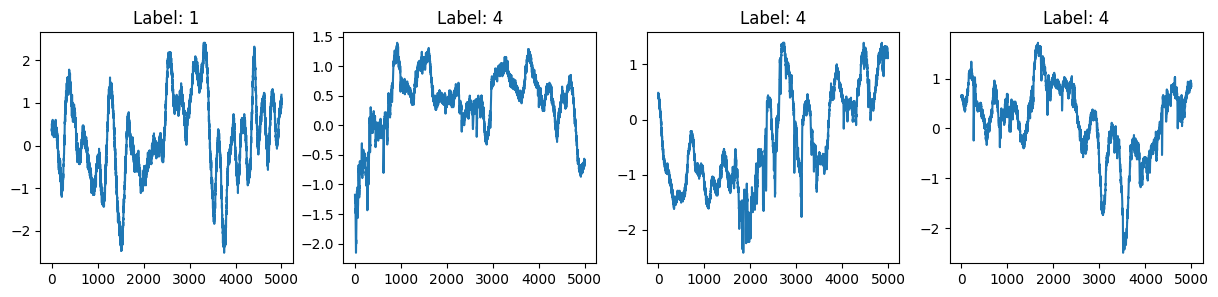

Batch 2/2
Inputs shape: torch.Size([64, 1, 5000])
Labels shape: torch.Size([64])
Labels: tensor([3, 3, 3, 0, 0, 0, 0, 1, 0, 4, 0, 4, 0, 0, 4, 1, 4, 4, 0, 4, 1, 4, 4, 3,
        0, 4, 1, 4, 4, 4, 0, 4, 1, 1, 0, 2, 0, 4, 4, 0, 1, 4, 2, 4, 0, 4, 0, 1,
        4, 1, 0, 2, 0, 0, 4, 1, 1, 4, 4, 1, 0, 3, 0, 4])


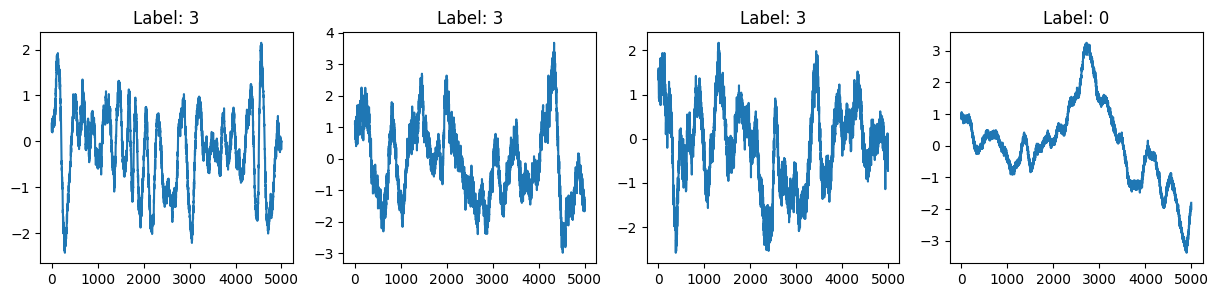

In [16]:
def inspect_train_loader(train_loader, num_batches=1):
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx + 1}/{num_batches}")
        print(f"Inputs shape: {inputs.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Labels: {labels}")
        
        # Visualizar algunas señales
        fig, axes = plt.subplots(1, min(4, inputs.shape[0]), figsize=(15, 3))
        for i in range(min(4, inputs.shape[0])):
            axes[i].plot(inputs[i].squeeze().numpy())
            axes[i].set_title(f"Label: {labels[i].item()}")
        plt.show()
        
        if batch_idx + 1 >= num_batches:
            break

# Usar la función para inspeccionar el train_loader
inspect_train_loader(train_loader, num_batches=2)

In [17]:
model = Deep_CNN_Signals(INPUT_SIZE, NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Inicializar la parada temprana
early_stopping = EarlyStopping(patience=10, delta=0.001)

model

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Deep_CNN_Signals(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=159744, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True

In [18]:
print("Training in: {}".format(DEVICE))
train_model(model, train_loader, optimizer, criterion, NUM_EPOCHS, device=DEVICE)
# evaluate_model(model, test_loader, dataset,  DEVICE, img_path='../plots', run_name=RUN_NAME)

Training in: cuda


Epoch 1/100:   0%|          | 0/164 [00:00<?, ?batch/s]

/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/danielcrovo/anaconda3/envs/ieeg/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 2/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/164 [00:00<?, ?batch/s]

KeyboardInterrupt: 

: 

In [18]:
torch.cuda.empty_cache()